In [56]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from comparator import Comparator, Indicator, visualize_contours
from scipy.spatial import KDTree
# 0=Neurons, 4=Astrocytes,5=Oligodendrocytes,11=Microglia,13=Endothelial #

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
clustann = pd.read_csv('/Users/brianbrogan/Desktop/KI24/ClusterImgGen2024/STERSEQ/output/01. Co-expression network/1996-081_GFM_SS200000954BR_A2_bin100_tissue_cleaned/Cluster_annotation.csv')
print(clustann.shape)
clustann.head()

(21441, 4)


,features,x,y,cluster
0,WASH7P,0.058166,8.574180,0
1,WASH9P,10.845608,10.232767,2
2,MTND1P23,-0.641904,10.953246,0
3,MTND2P28,-4.345322,8.884488,0
4,MTCO1P12,-0.549818,10.905572,0


In [26]:
duplicates = clustann[clustann.duplicated(subset=['features'], keep=False)]
print(duplicates.shape)
duplicates.head()

(0, 4)


,features,x,y,cluster


In [27]:
print(np.unique(clustann['cluster']))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74]


In [38]:
clust_0 = clustann.loc[clustann['cluster']==4, :]
print(clust_0.shape)
clust_0.head()


(54, 4)


,features,x,y,cluster
35,MXRA8,18.692465,10.252989,4
236,ESPNP,18.730371,10.231768,4
253,TAS1R2,18.150196,10.561714,4
1350,S100A2,18.511414,10.324617,4
1431,RAB25,18.462917,10.554472,4


In [39]:
clust_0_genes = np.unique(clust_0['features'])
print(clust_0_genes.shape)

(54,)


In [40]:
clust_0_gene_set = set(clust_0_genes)

In [41]:
sterseq_df = pd.read_csv('/Users/brianbrogan/Desktop/KI24/ClusterImgGen2024/STERSEQ/input/1996-081_GFM_SS200000954BR_A2_tissue_cleaned_cortex_crop.csv')

In [42]:
print(sterseq_df.shape)
sterseq_df.head()

(9084839, 8)


,Unnamed: 0,geneID,x,y,MIDCount,ExonCount,IntronCount,bin1_ID
0,1,WASH7P,4209,8106,1,0,1,159121569.0
1,2,WASH7P,8313,6307,1,0,1,123807705.0
2,3,WASH7P,6394,8031,1,0,1,157651354.0
3,4,WASH7P,7620,10189,3,0,3,200018436.0
4,5,WASH7P,10163,8238,1,0,1,161718947.0


In [43]:
clust_0_sterseq_df = sterseq_df[sterseq_df['geneID'].isin(clust_0_gene_set)]

In [44]:
print(clust_0_sterseq_df.shape)
clust_0_sterseq_df.head()

(5682, 8)


,Unnamed: 0,geneID,x,y,MIDCount,ExonCount,IntronCount,bin1_ID
35433,35434,MXRA8,9143,6520,1,0,1,127990151.0
35434,35435,MXRA8,5622,9367,1,1,0,183878934.0
35435,35436,MXRA8,9205,9114,1,1,0,178915621.0
35436,35437,MXRA8,7778,7028,1,1,0,137961842.0
35437,35438,MXRA8,5364,11161,1,1,0,219098484.0


In [45]:
indicators = clust_0_sterseq_df['geneID'].value_counts()



In [46]:
# Display the top N most common genes (e.g., top 10)
top_n_common_genes = indicators.head(25)
print(top_n_common_genes)
#print(indicators[:20])

geneID
TCF12          754
STAT3          654
NOS1           311
ZSWIM7         302
DHCR7          279
ZNF44          253
AATF           251
KATNA1         229
NFKBIB         208
ANO1           183
CFAP20DC-DT    170
MCAM           150
TPTE2P6        123
PLS1           112
ENOSF1         106
CCNJL          102
PIWIL2          99
MXRA8           97
SCN10A          86
XAF1            85
ZNF440          85
MCM9            82
MOCOS           81
MUC16           81
TPTE2P5         66
Name: count, dtype: int64


In [35]:
gene_cluster_counts = sterseq_df.groupby(['cluster', 'geneID']).size().reset_index(name='count')
gene_cluster_counts.head()

KeyError: 'cluster'

In [ ]:
def find_gene_set(df, clust_id):
    clust = df.loc[df['cluster']==clust_id, :]
    clust_genes_set = set(np.unique(clust['features']))
    return clust_genes_set

def create_cluster_df(origin, clust_id):
    gene_set = find_gene_set(origin, clust_id)
    cluster_df = origin[origin['geneID'].isin(gene_set)]
    return cluster_df

def find_n_indicators(cluster_df, minimum_count):
    indicators = cluster_df['geneID'].value_counts()
    indicators = indicators.loc[indicators['count']>= minimum_count]
    return indicators

In [2]:
indicator = Indicator(
    origin_csv_fname='/Users/brianbrogan/Desktop/KI24/ClusterImgGen2024/STERSEQ/input/1996-081_GFM_SS200000954BR_A2_tissue_cleaned_cortex_crop.csv',
    annotation_fname='/Users/brianbrogan/Desktop/KI24/ClusterImgGen2024/STERSEQ/output/01. Co-expression network/1996-081_GFM_SS200000954BR_A2_bin100_tissue_cleaned/Cluster_annotation.csv'
)

comparator = Comparator(
    indicator=indicator
)


Finding negative indicators: 100%|██████████| 4/4 [00:00<00:00,  6.28cluster/s]


In [3]:
indicator.positive_indicators.head()


geneID
MT-RNR2    182774
MT-CO2      42167
MT-TV       39477
MT-CO3      39279
MT-ND1      34312
Name: count, dtype: int64

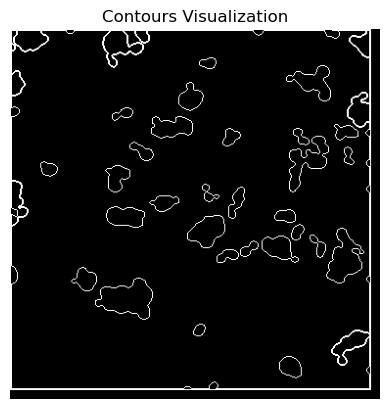

In [4]:
test_contours = comparator.contours.loc[4, 'contour_arrs']

visualize_contours(test_contours)
#comparator.run_single_comparison()

In [50]:
def get_points_in_contour(contour):
    # Flatten the contour to (n, 2)
    contour = contour.reshape((-1, 2))

    # Find the bounding box of the contour
    min_x, min_y = np.min(contour, axis=0)
    max_x, max_y = np.max(contour, axis=0)

    # Create a grid of points within the bounding box
    grid_points = [(x, y) for x in range(min_x, max_x+1) for y in range(min_y, max_y+1)]

    # Check which points are inside the contour using pointPolygonTest
    inside_points = [list(pt) for pt in grid_points if cv2.pointPolygonTest(contour, pt, False) >= 0]

    return inside_points

print(type(test_contours[4]))
print(test_contours[4].shape)

sing_contour = test_contours[20]#.reshape((-1, 2))
print(sing_contour.shape)

points_inside = get_points_in_contour(sing_contour)
print(len(points_inside))
print(points_inside)

<class 'numpy.ndarray'>
(39, 1, 2)
(81, 1, 2)
465
[[97, 144], [98, 143], [98, 144], [98, 145], [99, 142], [99, 143], [99, 144], [99, 145], [99, 146], [100, 142], [100, 143], [100, 144], [100, 145], [100, 146], [100, 147], [100, 150], [100, 151], [100, 152], [100, 153], [100, 154], [100, 155], [100, 156], [100, 157], [100, 158], [100, 159], [100, 160], [100, 161], [100, 162], [101, 142], [101, 143], [101, 144], [101, 145], [101, 146], [101, 147], [101, 148], [101, 149], [101, 150], [101, 151], [101, 152], [101, 153], [101, 154], [101, 155], [101, 156], [101, 157], [101, 158], [101, 159], [101, 160], [101, 161], [101, 162], [101, 163], [102, 142], [102, 143], [102, 144], [102, 145], [102, 146], [102, 147], [102, 148], [102, 149], [102, 150], [102, 151], [102, 152], [102, 153], [102, 154], [102, 155], [102, 156], [102, 157], [102, 158], [102, 159], [102, 160], [102, 161], [102, 162], [102, 163], [102, 164], [103, 142], [103, 143], [103, 144], [103, 145], [103, 146], [103, 147], [103, 148]

In [55]:

comp_points = comparator.get_contour_points(sing_contour)
count = comparator.run_single_comparison(sing_contour, 'MT-RNR2')
print(len(comp_points))
print(count)

182774
465
0


In [43]:
def view_contour(contour):
    # Flatten the contour and extract x, y coordinates
    x_vals, y_vals = zip(*[point[0] for point in contour])
    min_x, max_x = min(x_vals), max(x_vals)
    min_y, max_y = min(y_vals), max(y_vals)
    margin = 10
    min_x, max_x = min_x - margin, max_x + margin
    min_y, max_y = min_y - margin, max_y + margin
    adjusted_contour = contour - np.array([[min_x, min_y]])
    image_width = max_x - min_x + 1
    image_height = max_y - min_y + 1
    image = np.zeros((image_height, image_width), dtype=np.uint8)
    cv2.drawContours(image, [adjusted_contour], -1, 255, thickness=1)
    plt.imshow(image, cmap='gray')
    plt.title("Contour Visualization")
    plt.axis("off")
    plt.show()

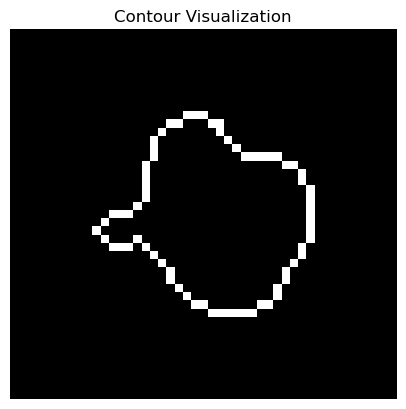

In [62]:
id = 34
focus = test_contours[id]


view_contour(focus)

In [57]:
def create_binary_mask(gene_coords, x_range, y_range, threshold=1):
    # Create KDTree from gene coordinates
    tree = KDTree(gene_coords)
    
    # Create an empty mask
    width, height = x_range[1] - x_range[0], y_range[1] - y_range[0]
    mask = np.zeros((height, width), dtype=np.uint8)
    
    # Generate grid points in the specified range
    for y in range(y_range[0], y_range[1]):
        for x in range(x_range[0], x_range[1]):
            # Query the KDTree for the nearest gene
            dist, _ = tree.query([x, y], k=1)
            if dist < threshold:
                mask[y - y_range[0], x - x_range[0]] = 255  # Set white for nearby genes
    
    return mask

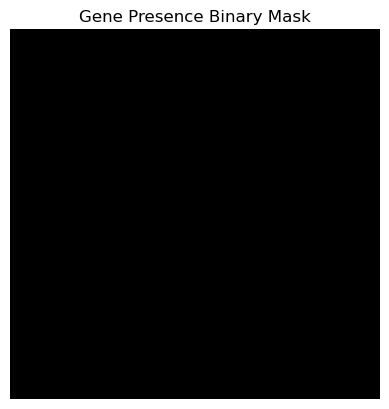

In [61]:
geneID_subset = comparator.origin_df.loc[comparator.origin_df['geneID']=='MT-RNR2']
gene_coords = geneID_subset[['x', 'y']].to_numpy()

#gene_coords = np.array([[10, 10], [15, 20], [50, 60], [70, 80]])  # Example gene coordinates
x_range, y_range = (0, 1000), (0, 1000)
binary_mask = create_binary_mask(gene_coords, x_range, y_range)

# Display the mask
plt.imshow(binary_mask, cmap='gray')
plt.title("Gene Presence Binary Mask")
plt.axis("off")
plt.show()